### An introduction to how machine learning can help us analyze millions of solar spectra efficiently 
#### Notebook 2. Dimensionality reduction  

*by Brandon Panos*$^{1,2}$  

1 *University of Applied Sciences and Arts Northwestern Switzerland, Bahnhofstrasse 6, 5210 Windisch, Switzerland*  
2 *University of Geneva, CUI-SIP, 1205 Geneva, Switzerland*

**----------------------------------------------------------------------------------------------------------------------------**

Each spectrum in our <font color='coral'>flare (FL)</font> and <font color='dodgerblue'>quiet Sun (QS)</font> datasets consist of 240 lambda points and therefore exist within a 240-dimensional space. Since humans can only visualize data in two or three dimensions (disregarding color etc), a host of techniques referred to as dimensionality reduction techniques have been invented that allow us to construct accurate representations of high dimensional datasets within the confines of three or fewer dimensions. These techniques allow us to visually explore and analyze our data in an intuitive way.  

In this notebook, we will try to project our high dimensional data onto a two dimensional plane using two methods: The classical principal component analysis (PCA) method of <font color='dodgerblue'> Hotelling, 1933</font>, and the more modern t-distrusted stochastic neighborhood embedding (t-SNE) method of <font color='dodgerblue'> van der Maaten & Hinton 2008</font>.  

### Theory  

The geometry of the dataset is fully captured by the symmetric square distance matrix $\mathbf{D}$ of all point-wise distances, where the entry $d_{ij} \in \mathbf{D}$ represents the Euclidean distance between points $x_i$ and $x_j$. Here, $x\in \mathcal{R}^n$, where n is some large value, in our case 240. The game here is to represent the original distribution of data with a new distribution of points living in $\mathcal{R}^{n\leq3}$. Once we have decided on where to place each data instance, we can measure the distances between each point and construct a new distance matrix $\mathbf{D}^\dagger$, with the objective that it preserve some key aspects of the original matrix $\mathbf{D}$. For some concrete examples, consider the following figure which shows three examples of embedding data from 2-dimensions into 1-dimension.  

<img src="pics/embedding_theory2.png" width="1000">  
Panel A shows the circumstance where no information is lost since the data occupies a sub- space of the full feature space. Panel B shows the circumstance where the actual distance information between points is lost, however the topological structure is maintained (all points are still equidistance from one another). Panel C shows the circumstance where both geometric and topological information cannot be preserved. The third case is the most common, and each technique has to chooses what information to forfeit and what information to preserve.  

<img src="pics/dim_red.png" width="1000">  

Above is an example of dimensionality reduction applied to a Swiss roll (top) and half sphere (bottom). In both cases we go from a high dimension of three, to a low two dimensional representation. Notice that although the structures are compromised, certain topological features are faithful preserved  

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn import preprocessing
from IPython.display import Image
from sklearn.decomposition import PCA
from sklearn import manifold, datasets
import matplotlib.gridspec as gridspec
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 15
np.random.seed(1)

### Method 1. Principal component analysis (PCA)

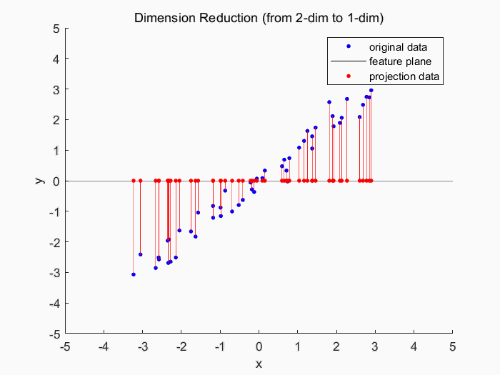

In [19]:
with open('pics/pca_gif.gif','rb') as f:
    display(Image(data=f.read(), format='png', width = 1000, height = 1000))
# Animation from https://www.programmersought.com/

The objective of PCA is to find the projection that maximizes the variance of the data. In the above animation, the data is projected orthogonally onto a one dimensional rotating line. Since the maximum variance of the data is along the diagonal from the bottom left to the top right, the optimal projection according to the PCA formalism is along the y=x line. This projection can be seen in the left panel below. Notice that projecting the data in this way results in the greatest spread (variance) of the red points in one dimension. The unit vector pointing in the direction of this projection is called the ***first principal component***. The panel on the right shows the second principal component which is orthogonal to the first. The principal components correspond to the eigenvectors of the covariance matrix. Eigenvectors with larger eigenvalues capture more of the data's variance.

<table><tr>
<td> <img src="pics/pca_first_comp.png" width="500">  </td>
<td> <img src="pics/pca_second_comp.png" width="500">  </td>
</tr></table>

### Real data  
We will import some data that was taken by NASA's Interface Region Imaging Spectrograph (IRIS) small explorer spacecraft (<font color='dodgerblue'>De Pontieu et al. 2014</font>).
<img src="pics/IRIS_SDO.png" width="1000">  
This image was taken from the cover of the journal **Science** 17 October 2014. The IRIS satellite sees the boxed region and has a spectrometer (seen here as a black slit) that collects light from different atomic transitions. This light is called spectra and forms the principal data type that we study.  

### Lets import the two spectral datasets
1. Mg II spectra collected from a solar flare (FL) <font color='coral'>FL_20140910_112825_3860259453</font>
2. Mg II spectra from the quiet Sun (QS) <font color='dodgerblue'>QS_20151010_233413_3620005935</font>    

The spectra for the flare dataset is stored in a numpy array called <font color='coral'>fl_spectra</font>. Each row is a different spectra of length 240. Similarly, the quiet Sun dataset is stored in a numpy array called <font color='dodgerblue'>qs_spectra</font>. Each spectrum can be described in terms of several features found in the variables <font color='coral'>fl_features</font> and <font color='dodgerblue'>qs_features</font>.

In [2]:
# Load quiet Sun dataset
with open('data/qs_spectra.p', 'rb') as f: qs_spectra = pickle.load(f)
with open('data/qs_features.p', 'rb') as f: qs_features = pickle.load(f)
# Load flare dataset
with open('data/fl_spectra.p', 'rb') as f: fl_spectra = pickle.load(f)
with open('data/fl_features.p', 'rb') as f: fl_features = pickle.load(f) 

The datasets consist of a large matrix, with each row containing a different Mg II spectrum (152456, 240). In the quiet Sun dataset there are 152456 spectra of dimensions 240. Each of these 152456 spectra have 6 features found in the dictionary "qs_features" dict_keys(['intensity', 'triplet_intensity', 'line_width', 'line_asymmetry', 'total_continium', 'kh_ratio']). The following figure shows what each features measures

<img src="pics/features.png" width="1000">

Before we begin, one of these techniques is computationally expensive, therefore, to save time we will write a function that randomly samples spectra from our dataset. This way we can gain a good representation of our data while keeping the computational cost low. 

In [4]:
def sample_spectra(spectra, features, sample_size=50000):
    '''
    input: spectral --> data from matrix (examples, lambda points)
           features --> Dictionary containing the six features of each spectrum
           
    output: sample_spectra --> sample of spectra
            sample_features --> corresponding feature dictionary 
    ''' 
    inds = np.random.randint(spectra.shape[0], size=sample_size)
    sample_spectra = spectra[inds, :]
    
    sample_features = {}
    for key, vals in features.items():
        sample_features[key] = features[key][inds]
        
    return sample_spectra, sample_features

In [5]:
qs_sample_spectra, qs_sample_features = sample_spectra(qs_spectra, qs_features, sample_size=50000)
fl_sample_spectra, fl_sample_features = sample_spectra(fl_spectra, fl_features, sample_size=50000)

We will now join both the QS and FL datasets into one big matrix and list of features while still keeping track of which dataset each spectrum comes from 

In [5]:
def join_and_label(spectra1, features1, spectra2, features2):
    '''
    output: spectra --> combined spectra from from QS and FL datasets (examples, lambda points)
            features --> combined feature list 
            spectra_y --> binary value of length |examples| indicates which spectrum is from the flare 
            or the quiet Sun dataset
    '''
    spectra = np.concatenate((spectra1, spectra2), axis = 0)
    
    features = {}
    for key, vals in features1.items():
        features[key] =  np.concatenate((vals, features2[key]))
    
    spectra_1y = np.full((1,len(spectra1)), 0)
    spectra_2y = np.full((1,len(spectra2)), 1)
    spectra_y = np.concatenate((spectra_1y, spectra_2y), axis = 1)
    spectra_y = np.squeeze(spectra_y)
    
    return spectra, features, spectra_y

In [7]:
spectra, features, spectra_y  = join_and_label(fl_sample_spectra, 
                                               fl_sample_features, 
                                               qs_sample_spectra, 
                                               qs_sample_features)

### Apply PCA to real data  
Instead of projecting the data onto a single line like in the above example, we can use the sklearn library to find the first two principal components of our data, and then form a two dimensional plane that is spanned by these components. The 240-dimensional spectra can then be projected onto this surface, and hopefully we can learn something about our data from pure visual inspection. 

In [8]:
# Create a PCA model 
n_components = 2 
pca = PCA(n_components=n_components, whiten=True)
projected_spectra = pca.fit_transform(spectra)

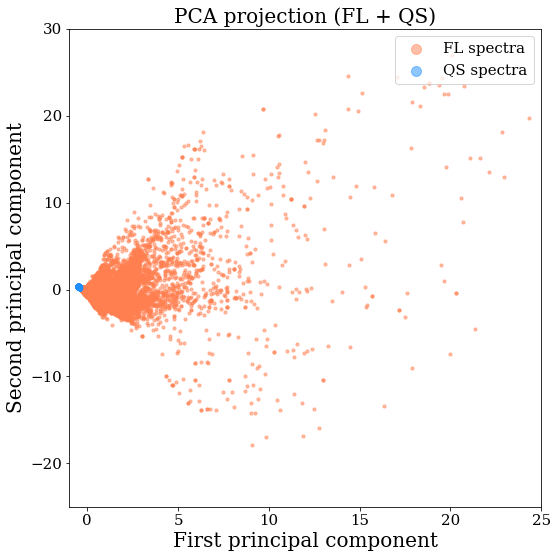

In [37]:
# Create QS and FL masks
FL = spectra_y == 0
QS = spectra_y == 1

# plot the projected spectra
plt.figure(figsize=(8, 8))

plt.scatter(projected_spectra[FL, 0], projected_spectra[FL, 1], c="coral", s = 10, alpha=.5, label='FL spectra')  
plt.scatter(projected_spectra[QS, 0], projected_spectra[QS, 1], c='dodgerblue', s = 10, alpha=.5, label='QS spectra')

plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title('PCA projection (FL + QS)', fontsize=20)
plt.xlabel('First principal component', fontsize=20)
plt.ylabel('Second principal component', fontsize=20)
lgnd = plt.legend(loc="upper right", numpoints=1, fontsize=15)
lgnd.legendHandles[0]._sizes = [100]
lgnd.legendHandles[1]._sizes = [100]
plt.xlim(-1,25)
plt.ylim(-25,30)
plt.tight_layout()

The <font color='coral'>flare</font> spectra appear to be much more spread out than the <font color='dodgerblue'>quiet Sun</font> spectra. This is often the case when a single variable overpowers the other variables by extending over a larger range of values. In this case, all the other interesting aspects of the data are washed out.

## ! Exercises

In [ ]:
'''
Q1) Prove that this spread is due to the intensity of the spectra 
by using a colormap to visualize each spectrums intensity  

Hint: cm = plt.cm.get_cmap('seismic') can be used in a scatter plot
      Look at the above scatter plot and adapt
''' 

### CODE HERE 


### CODE HERE 

In [39]:
'''
Q2) Lets get rid of the intensity variable by normalize the centroids
Normalize each flare spectra by its maximum value using numpy in one line. Return a matrix of the same dimensions
''' 


### CODE HERE 

spectra_norm =

### CODE HERE 

In [40]:
'''
Q3) Project the spectra again using the pca class from sklearn
'''

### CODE HERE 


### CODE HERE 

In [71]:
'''
Q4) Plot the results
'''

### CODE HERE 


### CODE HERE 

In [ ]:
'''
Q5) Create a function that allows you to easily plot the feature values of any point using a color map
You should be able to input one of the six features as an argument and get out a different map  
'''

### CODE HERE 


### CODE HERE 

In [ ]:
'''
Q6) Plot for every feature  
'''

### CODE HERE 


### CODE HERE 

## ! End of exercises

Although PCA is extremely fast, it preferences the preservation of global structures over local structure. To demonstrate this consider the following figure  
<img src="pics/pca_tsne.png" width="1000">  
We have four clusters of data represented by the four semicircles. Since the distance $\Delta D$ is much larger than the distances $\Delta d$ separating two neighboring clusters, the first principal component is along the diagonal as shown, and PCA projects the data in such a way that the two clusters separated by $\Delta d$ in two dimensions land on top of one another in the one dimensional space $F^\prime$. We might want to evaluate the structure of the data at all length scales, both locally and globally. The next method allows us to probe the data at different length scales, returning a projection more similar to that seen in the right hand panel.  

### Method 2. t-distrusted stochastic neighborhood embedding (t-SNE)  

We will use the figure below to briefly discuss the mechanism behind the t-SNE algorithm. For more details see the original paper <font color='dodgerblue'>(van der Maaten & Hinton 2008 JMLR)</font> as well as our application <font color='dodgerblue'>(Panos & Kleint 2020 ApJ)</font>. An interactive and intuitive explanation can be found at the following link https://distill.pub/2016/misread-tsne/.  

### ***The mechanics behind the t-SNE algorithm***   

<img src="pics/t_SNE.png" width="1000">  

***1) Statistical distance:*** Replace the geometric distance measure for a statistical distance measure. This is done by placing Gaussian distributions $g_i$ over each data point. The distance between any two points is then measured as the overlap between their Gaussians (blue region in the top left panel). With these overlaps we can calculate the statistical distance matrix $P$.

***2) Information entropy:*** We set a single variable called the perplexity. This value is proportional to the distributions ***Shannon entropy***. The variance of each Gaussian adapts according to the local underlying density of points in order to maintain the specified entropy. Notice that the Gaussian $g_j$ rippling out from the black data point has a much smaller variance than the Gaussian $g_i$ emanating from the grey point, since the black cluster is tighter than the grey. This means that our "measuring stick" is determined by the data's density, and is a key component in how t-SNE allows us to capture structure at all scales.

***3) KL-divergence:*** Randomly place the points in the lower dimension as seen in the right hand panel. Use a students t-distribution to measure the the statistical distance between the points. Use this information to construct a statistical distance matrix $P^\dagger$. Use the KL-divergence to measure the dissimilarity between $P$ and $P^\dagger$

***4) Gradient descent:*** Use gradient descent to minimize this the divergence. This results in the restructuring and reconfiguration of the location of points in the lower dimension until $P^\dagger$ is as close to $P$ as possible. 

### Apply t-SNE to real data

In [6]:
# Reduce the sample size
qs_sample_spectra, qs_sample_features = sample_spectra(qs_spectra, qs_features, sample_size=5000)
fl_sample_spectra, fl_sample_features = sample_spectra(fl_spectra, fl_features, sample_size=5000)

# Join the datasets
spectra, features, spectra_y  = join_and_label(fl_sample_spectra, 
                                               fl_sample_features, 
                                               qs_sample_spectra, 
                                               qs_sample_features)

## ! Exercises

In [55]:
'''
Q7) Instead of performing the projections directly on the 240 dimenstional spectra, 
lets rather project the six features of each spectrum.

Create a matrix called "feature_matrix", where each row consists of a single spectrums six features
Hint: Use a for loop over the dictionary "features"

If you print( feature_matrix.shape ) you should get (10000, 6)
'''

In [29]:
'''
Q8) Plot the projected spectra for different perplexities: suggestions [1,2,13,50,150,450]
You can use the same pattern as we did for PCA but with an additional parameter "perplexity"

n_components = 2
tsne = manifold.TSNE(n_components=n_components, init='random', perplexity=450)
projected_spectra = tsne.fit_transform(feature_matrix)
'''

In [58]:
'''
Q9) Select a perplexity and overplot each points features just like we did with PCA value using six different plots
'''

## ! End of exercises